In [2]:
import numpy as np
import os
from skimage.io import imread, imsave
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

In [ ]:
fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{position}.ome.tif'
fname_mask = 'mask_' + fname
path_im = os.path.join(path,scope_name,exp_date,fname)
path_mask = os.path.join(path,scope_name,exp_date,masks_folder,fname_mask)

fname

In [ ]:
save_quivers('somepath', 'quiver_image_%04d.png', 'quiver_plain_%04d.png', 64, 64, nt, vel, pos, normed=False)


In [75]:
plt.figure(figsize=(6,6))
def save_quivers(outdir, file_pattern1, file_pattern2, w,h, nt, vel, pos, normed=False):
    #pos = self.pos()
    #vel = self.vel()
    for t in range(nt):
        print(t)
        im = images[t]
        plt.imshow(im/np.max(im),cmap='gray', origin='lower')
        if normed:
            norm = np.sqrt(vel[:,:,t,0]**2 + vel[:,:,t,1]**2)
        else:
            norm = 1
        vx = vel[:,:,t,0]
        vy = vel[:,:,t,1]
        plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm,cmap='gray')
        #fname = os.path.join(outdir, file_pattern1%(t))
        #plt.savefig(fname)
        plt.show()
        #plt.clf()
        #plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm)
        #fname = os.path.join(outdir, file_pattern2%(t))
        #plt.savefig(fname)
        #plt.show()
        #plt.clf()

<Figure size 600x600 with 0 Axes>

In [3]:
# Fit an exponential decay model to the velocity data
def residual_func(edt, nvmag, nt, nx, ny):
    def residuals(x):
        r0 = np.exp(x[0])
        C = 0  # x[1]
        res = []
        for frame in range(0,nt):
            for ix in range(nx):
                for iy in range(ny):
                    if not np.isnan(nvmag[frame, ix, iy]) and vfront[frame] > 1:
                        r = edt[frame, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                        #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                        R = rmax[t]
                        B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                        model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
                        #B = 1 / (1 - np.exp(-rmax[t] / r0))
                        #model_vmag = 1 + B * (np.exp(-r / r0) - 1)                    
                        mean_model_vmag = vfront[frame] * np.nanmean(model_vmag)
                        res.append(mean_model_vmag - nvmag[frame, ix, iy])
        return res
    return residuals

#### Displaying velocity results

In [6]:
pos = 0
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
scope_name = 'Ti scope'
exp_date = '2023_11_15'
folder_velocity = 'velocity_data'
folder_masks = 'contour_masks'
folder_results = 'results'
folder_graphs = 'graphs'
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
vector = 'pLPT20&pLPT41'
#vector = 'pAAA'
fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname
path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_im = os.path.join(path, fname)


#### Fit velocity

pos0


/tmp/ipykernel_641938/1225230577.py:23: RuntimeWarning: Mean of empty slice
  svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])


r0 = 22.48865881767588, C = 0


/tmp/ipykernel_641938/1225230577.py:64: RuntimeWarning: invalid value encountered in scalar divide
  model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
/tmp/ipykernel_641938/1225230577.py:68: RuntimeWarning: Mean of empty slice
  mean_model_vmag = np.nanmean(model_vmag)


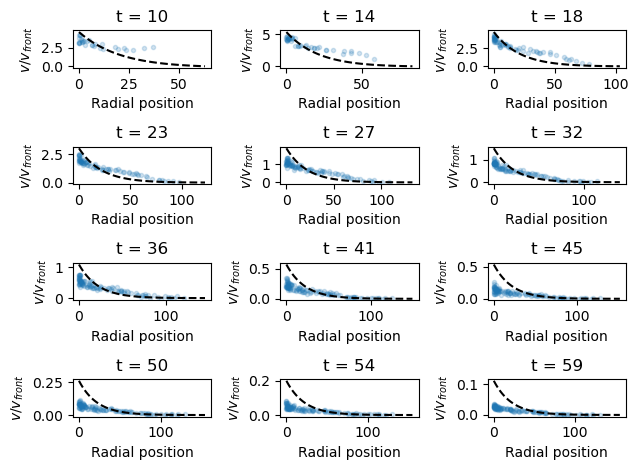

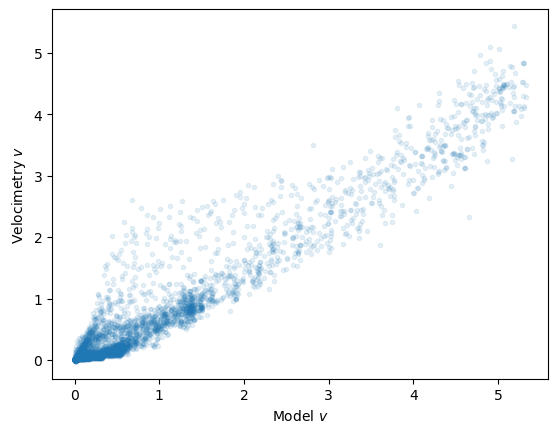

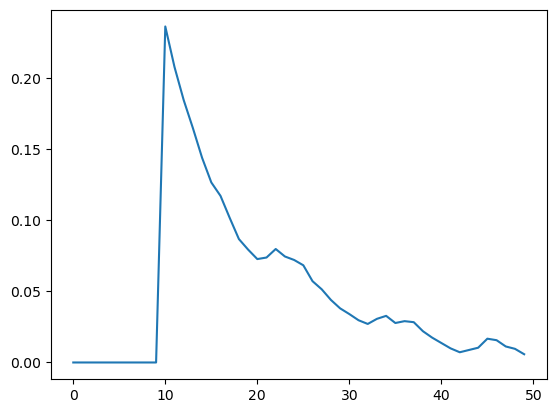

In [8]:
for pos in [0]:
    print(f"pos{pos}")
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    path_graphs = os.path.join(path, folder_graphs, f"pos{pos}")
    start_frame = 0
    t0 = 10
    tf = 60
    step = 1
    
    vmag = np.load(os.path.join(path_results, 'vmag.npy'))
    vmag = vmag[t0:tf, :, :]
    nt, nx, ny = vmag.shape
    vfront = np.load(os.path.join(path_results, 'vfront.npy'))
    rmax = np.load(os.path.join(path_results, 'radius.npy'))
    idx = np.arange(start_frame+t0,nt+start_frame+t0)
    vfront = vfront[idx]
    rmax = rmax[idx]
    
    svmag = np.zeros_like(vmag) + np.nan
    for t in range(0,nt):
        for ix in range(1, nx - 1):
            for iy in range(1, ny - 1):
                svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])
    
    nvmag = np.zeros_like(svmag)
    for frame in range(0,nt):
        #nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step + start_frame]
        nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step]
    
    radpos = np.load(os.path.join(path_results, 'radpos.npy'))
    radpos = radpos[idx, :, :]
    edt = np.load(os.path.join(path_results, 'edt.npy'))
    edt = edt[idx, :, :]
    res = least_squares(residual_func(edt, svmag, nt, nx, ny), x0=(np.log(50),))
    r0 = np.exp(res.x[0])
    C = 0  # res.x[1]
    #np.save(os.path.join(path_results, 'r0.npy'), r0)
    
    print(f'r0 = {r0}, C = {C}')
    
    # Make a plot to see how good the fit is
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    i = 0
    times = np.linspace(0, nt - 1, 12).astype(int)  # [0,int(nt/3),int(2*nt/3),nt-1]
    for t in times:
        plt.subplot(4, 3, i + 1)
        x_model = np.zeros((0,))
        y_model = np.zeros((0,))
        x_data = np.zeros((0,))
        y_data = np.zeros((0,))
    
        for ix in range(nx):
            for iy in range(ny):
                if not np.isnan(svmag[t, ix, iy]):
                    r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                    #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                    x_data = np.append(x_data, np.nanmean(r))
                    y_data = np.append(y_data, svmag[t, ix, iy])
        plt.plot(x_data, y_data, '.', alpha=0.2)  # , color=colours[i])
    
        for r in np.linspace(0, rmax[t], 100):
            R = rmax[t]
            B = R / ((R - r0) + r0 * np.exp(-R / r0))    
            model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
    
            #B = 1 / (1 - np.exp(-rmax[t] / r0))
            #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
            mean_model_vmag = np.nanmean(model_vmag)
            x_model = np.append(x_model, np.nanmean(r))
            #y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
            y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)
    
        plt.plot(x_model, y_model, 'k--')  # , color=colours[i])
    
        i += 1
    
        plt.title(f't = {idx[t]}')
        plt.xlabel('Radial position')
        plt.ylabel('$v/v_{front}$')
    plt.tight_layout()
    #plt.savefig(os.path.join(path_graphs, 'vfront_rad.png'))
    plt.show()
    
    y_model = np.zeros((0,))
    y_data = np.zeros((0,))
    for t in range(0,nt):
        for ix in range(nx):
            for iy in range(ny):
                if not np.isnan(svmag[t, ix, iy]):
                    r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                    #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                    R = rmax[t]
                    B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                    model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
                    #B = 1 / (1 - np.exp(-rmax[t] / r0))
                    #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
                    mean_model_vmag = np.nanmean(model_vmag)
                    #y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
                    y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)
                    y_data = np.append(y_data, svmag[t, ix, iy])
    
    plt.plot(y_model, y_data, '.', alpha=0.1)
    #plt.plot([0, y_model.max()], [0, y_model.max()], 'k--')
    plt.xlabel('Model $v$')
    plt.ylabel('Velocimetry $v$')
    #plt.savefig(os.path.join(path_graphs, 'model_graph.png'))
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()
    
    mu0 = np.zeros((nt,))
    for t in range(t0,nt):
    
        R = rmax[t]
        B = R / ((R - r0) + r0 * np.exp(-R / r0))
        mu0[t] = vfront[t] / r0 * B
    
        #B = 1 / (1 - np.exp(-rmax[t] / r0))
        #mu0[t] = 2 * vfront[step * t] / r0 * B
    
    # The edge growth rate = 2 * edge velocity / r0 
    plt.plot(mu0)
    #plt.savefig(os.path.join(path_graphs, 'mu0_profile.png'))
    plt.show()
    #np.save(os.path.join(path_results, 'mu0.npy'), mu0)
